## PROJECT 4 - Airline Delay and Cancellation Prediction with Spark ML

###  Imports & Spark Session 

In [1]:
import pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import (StructType, StructField, IntegerType, StringType,
                               DoubleType, DateType)
from pyspark.storagelevel import StorageLevel

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import (LogisticRegression, DecisionTreeClassifier,
                                       RandomForestClassifier, GBTClassifier)
from pyspark.ml.evaluation import (BinaryClassificationEvaluator,
                                   MulticlassClassificationEvaluator)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Start Spark session
spark = SparkSession.builder \
    .appName("Airline_Delay_Cancel_Prediction") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(f"Spark {spark.version} initialised !")

Spark 3.5.3 initialised !


### Data Ingestion

In [2]:
# Define schema based on cleaned names for explicit loading (alternative to inferSchema)
# This provides more control and avoids an extra Spark job for inference.

schema = StructType([
    StructField("FL_DATE", DateType(), True),
    StructField("OP_CARRIER", StringType(), True),
    StructField("OP_CARRIER_FL_NUM", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("CRS_DEP_TIME", IntegerType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", IntegerType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ACTUAL_ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("CARRIER_DELAY", DoubleType(), True),
    StructField("WEATHER_DELAY", DoubleType(), True),
    StructField("NAS_DELAY", DoubleType(), True),
    StructField("SECURITY_DELAY", DoubleType(), True),
    StructField("LATE_AIRCRAFT_DELAY", DoubleType(), True),
    StructField("Unnamed: 27", StringType(), True)
])


TRAIN_PATH = "input/2009.csv"
TEST_PATH  = "input/2010.csv"

flights_2009 = spark.read.format("csv") \
    .option("header", "true") \
    .option("ignoreLeadingWhiteSpace", "true") \
    .option("ignoreTrailingWhiteSpace", "true") \
    .schema(schema) \
    .load(TRAIN_PATH)

test_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("ignoreLeadingWhiteSpace", "true") \
    .option("ignoreTrailingWhiteSpace", "true") \
    .schema(schema) \
    .load(TEST_PATH)

# Print the schema to verify data types
print("DataFrame Schema:")
flights_2009.printSchema()

DataFrame Schema:
root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- W

In [3]:
# Data Writing as Partitioned Parquet for Scalability
parquet_path = "output/parquet/flight_2009_partitioned"
#flights_2009.write.mode("overwrite").partitionBy("Month", "DayOfWeek").parquet(parquet_path)


### Cleaning & Preprocessing

In [4]:
renamed_columns = [
    "Date", "UniqueCarrier", "FlightNumber", "Origin", "Destination",
    "CRSDepTime", "DepartureTime", "DepartureDelay", "TaxiOut", "WheelsOff",
    "WheelsOn", "TaxiIn", "CRSArrivalTime", "ArrivalTime", "ArrivalDelay",
    "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime",
    "ActualElapsedTime", "AirTime", "Distance", "CarrierDelay",
    "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay",
    "UnusedColumn"
]

flights_2009 = flights_2009.toDF(*renamed_columns)

test_df = test_df.toDF(*renamed_columns)

In [5]:
flights_2009 = flights_2009.withColumn("DayofWeek", F.dayofweek("Date")) \
                     .withColumn("Month", F.month("Date"))

test_df = test_df.withColumn("DayofWeek", F.dayofweek("Date")) \
                     .withColumn("Month", F.month("Date"))

In [6]:
flights_2009.select([
    F.count(F.when(F.col(c).isNull() | (F.isnan(c) if dict(flights_2009.dtypes)[c] in ('double', 'float') else F.lit(False)), c)).alias(c)
    for c in flights_2009.columns
]).show()


+----+-------------+------------+------+-----------+----------+-------------+--------------+-------+---------+--------+------+--------------+-----------+------------+---------+----------------+--------+--------------+-----------------+-------+--------+------------+------------+--------+-------------+-----------------+------------+---------+-----+
|Date|UniqueCarrier|FlightNumber|Origin|Destination|CRSDepTime|DepartureTime|DepartureDelay|TaxiOut|WheelsOff|WheelsOn|TaxiIn|CRSArrivalTime|ArrivalTime|ArrivalDelay|Cancelled|CancellationCode|Diverted|CRSElapsedTime|ActualElapsedTime|AirTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|UnusedColumn|DayofWeek|Month|
+----+-------------+------------+------+-----------+----------+-------------+--------------+-------+---------+--------+------+--------------+-----------+------------+---------+----------------+--------+--------------+-----------------+-------+--------+------------+------------+--------+-------------+-

In [7]:
test_df.select([
    F.count(F.when(F.col(c).isNull() | (F.isnan(c) if dict(test_df.dtypes)[c] in ('double', 'float') else F.lit(False)), c)).alias(c)
    for c in test_df.columns
]).show()

+----+-------------+------------+------+-----------+----------+-------------+--------------+-------+---------+--------+------+--------------+-----------+------------+---------+----------------+--------+--------------+-----------------+-------+--------+------------+------------+--------+-------------+-----------------+------------+---------+-----+
|Date|UniqueCarrier|FlightNumber|Origin|Destination|CRSDepTime|DepartureTime|DepartureDelay|TaxiOut|WheelsOff|WheelsOn|TaxiIn|CRSArrivalTime|ArrivalTime|ArrivalDelay|Cancelled|CancellationCode|Diverted|CRSElapsedTime|ActualElapsedTime|AirTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|UnusedColumn|DayofWeek|Month|
+----+-------------+------------+------+-----------+----------+-------------+--------------+-------+---------+--------+------+--------------+-----------+------------+---------+----------------+--------+--------------+-----------------+-------+--------+------------+------------+--------+-------------+-

In [8]:
cancelled_flights_df = flights_2009.filter(F.col("Cancelled") == 1)

print("Cancelled flights:", cancelled_flights_df.count())

cancelled_flights_df.select([
    F.count(F.when(F.col(c).isNull() | (F.isnan(c) if dict(flights_2009.dtypes)[c] in ('double', 'float') else F.lit(False)), c)).alias(c)
    for c in cancelled_flights_df.columns
]).show()

Cancelled flights: 87038
+----+-------------+------------+------+-----------+----------+-------------+--------------+-------+---------+--------+------+--------------+-----------+------------+---------+----------------+--------+--------------+-----------------+-------+--------+------------+------------+--------+-------------+-----------------+------------+---------+-----+
|Date|UniqueCarrier|FlightNumber|Origin|Destination|CRSDepTime|DepartureTime|DepartureDelay|TaxiOut|WheelsOff|WheelsOn|TaxiIn|CRSArrivalTime|ArrivalTime|ArrivalDelay|Cancelled|CancellationCode|Diverted|CRSElapsedTime|ActualElapsedTime|AirTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|UnusedColumn|DayofWeek|Month|
+----+-------------+------------+------+-----------+----------+-------------+--------------+-------+---------+--------+------+--------------+-----------+------------+---------+----------------+--------+--------------+-----------------+-------+--------+------------+------------

In [9]:
cancelled_test_df = test_df.filter(F.col("Cancelled") == 1)

print("Cancelled flights:", cancelled_test_df.count())

cancelled_test_df.select([
    F.count(F.when(F.col(c).isNull() | (F.isnan(c) if dict(test_df.dtypes)[c] in ('double', 'float') else F.lit(False)), c)).alias(c)
    for c in cancelled_test_df.columns
]).show()

Cancelled flights: 113255
+----+-------------+------------+------+-----------+----------+-------------+--------------+-------+---------+--------+------+--------------+-----------+------------+---------+----------------+--------+--------------+-----------------+-------+--------+------------+------------+--------+-------------+-----------------+------------+---------+-----+
|Date|UniqueCarrier|FlightNumber|Origin|Destination|CRSDepTime|DepartureTime|DepartureDelay|TaxiOut|WheelsOff|WheelsOn|TaxiIn|CRSArrivalTime|ArrivalTime|ArrivalDelay|Cancelled|CancellationCode|Diverted|CRSElapsedTime|ActualElapsedTime|AirTime|Distance|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|UnusedColumn|DayofWeek|Month|
+----+-------------+------------+------+-----------+----------+-------------+--------------+-------+---------+--------+------+--------------+-----------+------------+---------+----------------+--------+--------------+-----------------+-------+--------+------------+-----------

In [10]:
# Remove the columns with NULL values
flights_2009 = flights_2009.drop("UnusedColumn", "LateAircraftDelay", "SecurityDelay", "NASDelay", "WeatherDelay", "CarrierDelay", "AirTime", "ActualElapsedTime", "ArrivalDelay", "ArrivalTime", "TaxiIn", "WheelsOn")

test_df =   test_df.drop("UnusedColumn", "LateAircraftDelay", "SecurityDelay", "NASDelay", "WeatherDelay", "CarrierDelay", "AirTime", "ActualElapsedTime", "ArrivalDelay", "ArrivalTime", "TaxiIn", "WheelsOn")

In [11]:
flights_2009.describe().toPandas()

,summary,UniqueCarrier,FlightNumber,Origin,Destination,CRSDepTime,DepartureTime,DepartureDelay,TaxiOut,WheelsOff,CRSArrivalTime,Cancelled,CancellationCode,Diverted,CRSElapsedTime,Distance,DayofWeek,Month
0,count,6429338,6429338,6429338,6429338,6429338,6346471,6346471,6343551,6343551,6429338,6429338,87038,6429338,6429338,6429338,6429338,6429338
1,mean,None,2293.7116343859975,None,None,1319.4466834688112,1326.026277910984,7.598178735867539,16.036132759080836,1350.7975509300707,1496.7219118049168,0.013537630157257247,None,0.0023832935832584943,129.3446482359459,724.9700084207736,3.9334544240791196,6.403640779190641
2,stddev,None,2046.4974637636094,None,None,457.7529163543437,468.89401144957816,31.764943958809607,10.563825466907762,470.05145211129604,473.3177552778822,0.11556108689381757,None,0.04876078203599105,69.66364081735988,561.0229006051038,1.9522775240815613,3.337858994294268
3,min,9E,1,ABE,ABE,1,1.0,-96.0,1.0,1.0,1,0.0,A,0.0,1.0,11.0,1,1
4,max,YV,7829,YUM,YUM,2359,2400.0,2445.0,458.0,2400.0,2400,1.0,D,1.0,660.0,4962.0,7,12


In [12]:
#Filter out Diverted = 1 
flights_2009 = (
    flights_2009
    .filter(F.col("Diverted") != 1)  # keep only non-diverted flights
    .drop("Diverted")                # remove the Diverted column
)

test_df = (
    test_df
    .filter(F.col("Diverted") != 1)
    .drop("Diverted")
)

##  Exploratory Analysis

In [13]:
# Top 10 carriers
print("\n Top‑10 carriers by flight count (2009):")
(flights_2009.groupBy("UniqueCarrier")
        .count()
        .orderBy(F.desc("count"))
        .limit(10)
        .show())



 Top‑10 carriers by flight count (2009):
+-------------+-------+
|UniqueCarrier|  count|
+-------------+-------+
|           WN|1127045|
|           AA| 548194|
|           OO| 544843|
|           MQ| 434577|
|           DL| 424982|
|           US| 411274|
|           UA| 375501|
|           XE| 308340|
|           EV| 297874|
|           NW| 291856|
+-------------+-------+



In [14]:
# Cancellation reasons
print("\n Cancellation reasons count (A=carrier, B=weather, C=NAS, D=security):")
(flights_2009.filter(F.col("Cancelled") == 1)
        .groupBy("CancellationCode")
        .count()
        .orderBy(F.desc("count"))
        .show())
 


 Cancellation reasons count (A=carrier, B=weather, C=NAS, D=security):
+----------------+-----+
|CancellationCode|count|
+----------------+-----+
|               B|36651|
|               A|35568|
|               C|14799|
|               D|   20|
+----------------+-----+



In [15]:
# Class imbalance
class_dist = flights_2009.groupBy("Cancelled").count().collect()
neg, pos = sorted(class_dist, key=lambda r: r["Cancelled"])  # 0 then 1
imbalance_ratio = round(neg["count"] / pos["count"], 2)
print(f"Imbalance ratio (0 : 1) = {imbalance_ratio}")


Imbalance ratio (0 : 1) = 72.69


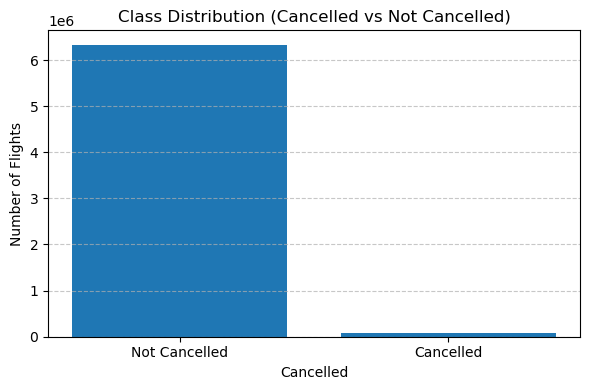

In [16]:
import matplotlib.pyplot as plt

# Prepare labels and counts
labels = ['Not Cancelled', 'Cancelled']
counts = [neg["count"], pos["count"]]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title('Class Distribution (Cancelled vs Not Cancelled)')
plt.xlabel('Cancelled')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Feature engineering

#### Categorical feature processing with StringIndexer + OneHotEncoder(Indexing and Encoding)

In [17]:
# Processing categorical features with StringIndexer + OneHotEncoder

categorical_cols = ['Origin', 'Destination', 'CRSDepTime', 'DayofWeek', 'Month'] 

indexers_and_encoders = []
print("Defining stages for categorical features:")
for cat_col in categorical_cols:
    index_col = cat_col + "_Index"
    vec_col = cat_col + "_Vec"

    # Indexer Stage
    string_indexer = StringIndexer(inputCol=cat_col, outputCol=index_col, handleInvalid='keep')
    indexers_and_encoders.append(string_indexer)
    print(f"  Added StringIndexer ({cat_col} -> {index_col})")

    # Encoder Stage
    encoder = OneHotEncoder(inputCols=[index_col], outputCols=[vec_col])
    indexers_and_encoders.append(encoder)
    print(f"  Added OneHotEncoder ({index_col} -> {vec_col})")

# Keep track of the output vector column names for the assembler
categorical_vec_cols = [col + "_Vec" for col in categorical_cols]

Defining stages for categorical features:
  Added StringIndexer (Origin -> Origin_Index)
  Added OneHotEncoder (Origin_Index -> Origin_Vec)
  Added StringIndexer (Destination -> Destination_Index)
  Added OneHotEncoder (Destination_Index -> Destination_Vec)
  Added StringIndexer (CRSDepTime -> CRSDepTime_Index)
  Added OneHotEncoder (CRSDepTime_Index -> CRSDepTime_Vec)
  Added StringIndexer (DayofWeek -> DayofWeek_Index)
  Added OneHotEncoder (DayofWeek_Index -> DayofWeek_Vec)
  Added StringIndexer (Month -> Month_Index)
  Added OneHotEncoder (Month_Index -> Month_Vec)


#### Label Indexing

In [18]:
label_col = 'Cancelled'
label_output_col = "label"

label_indexer = StringIndexer(inputCol=label_col, outputCol=label_output_col)
print(f"Added StringIndexer for label ({label_col} -> {label_output_col})")

Added StringIndexer for label (Cancelled -> label)


#### Feature Assembling

In [19]:
numerical_cols = ['CRSArrivalTime', 'CRSElapsedTime', 'Distance']
feature_output_col = "features"
assembler_inputs = categorical_vec_cols + numerical_cols

vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol=feature_output_col, handleInvalid='skip')
print(f"Added VectorAssembler to create '{feature_output_col}' from {len(assembler_inputs)} columns")

Added VectorAssembler to create 'features' from 8 columns


#### Applying the processing Pipeline

In [20]:
from pyspark.ml import Pipeline
preprocessing_pipeline = Pipeline(stages=indexers_and_encoders + [label_indexer, vector_assembler])
preprocessing_model    = preprocessing_pipeline.fit(flights_2009)

# Transform both 2009 and 2010
processed_2009 = preprocessing_model.transform(flights_2009)
processed_2010 = preprocessing_model.transform(test_df)

# Select only label & features, cache
model_input_df = processed_2009.select("label", "features").cache()
test_df_2010   = processed_2010.select("label", "features").cache()


## Modeling

In [21]:
# Split data (70% training, 30% testing)
split_ratio = [0.7, 0.3]
seed = 42 # Use a fixed seed for reproducibility

train_data, test_data = model_input_df.randomSplit(split_ratio, seed=seed)

# Cache the splits for performance during training and evaluation
train_data.cache()
test_data.cache()

DataFrame[label: double, features: vector]

#### Train 4 models

In [23]:
# Defining 4 models and their param‐grids:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr  = LogisticRegression(labelCol="label", featuresCol="features")
dt  = DecisionTreeClassifier(labelCol="label", featuresCol="features")
rf  = RandomForestClassifier(labelCol="label", featuresCol="features")
gbt = GBTClassifier(labelCol="label", featuresCol="features")

lr_grid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1]).build()
dt_grid = ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 10]).build()
rf_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20]).build()
gbt_grid = ParamGridBuilder().addGrid(gbt.maxIter, [10, 20]).build()

binary_eval = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
multi_eval = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)

In [24]:
# 5. Set up CrossValidators
def get_cv(model, grid):
    return CrossValidator(estimator=model,
                          estimatorParamMaps=grid,
                          evaluator=binary_eval,
                          numFolds=3)

cv_lr = get_cv(lr, lr_grid)
cv_dt = get_cv(dt, dt_grid)
cv_rf = get_cv(rf, rf_grid)
cv_gbt = get_cv(gbt, gbt_grid)

In [25]:
print("Training models, this may take a few minutes...")

lr_model = cv_lr.fit(train_data)
print("Logistic regression model fitted")

Training models, this may take a few minutes...
Logistic regression model fitted


In [26]:
dt_model = cv_dt.fit(train_data)
print("Decision tree model fitted")

Decision tree model fitted


In [27]:
rf_model = cv_rf.fit(train_data)
print("Random forest model fitted")

Random forest model fitted


In [28]:
gbt_model = cv_gbt.fit(train_data)
print("GBT model fitted")

GBT model fitted


#### Evaluate using both Accuracy and AUC metrics

In [30]:
# Evaluate models on test data
models = [("Logistic Regression", lr_model),
          ("Decision Tree", dt_model),
          ("Random Forest", rf_model),
          ("Gradient Boosted Tree", gbt_model)]

for name, model in models:
    predictions = model.transform(test_data)
    auc = binary_eval.evaluate(predictions)
    acc = multi_eval.evaluate(predictions)
    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")


Logistic Regression
Accuracy: 0.9864
AUC: 0.7428

Decision Tree
Accuracy: 0.9864
AUC: 0.5000

Random Forest
Accuracy: 0.9864
AUC: 0.5963

Gradient Boosted Tree
Accuracy: 0.9864
AUC: 0.7139


## Explainability

#### Extract and visualize feature importances from your best tree-based model.

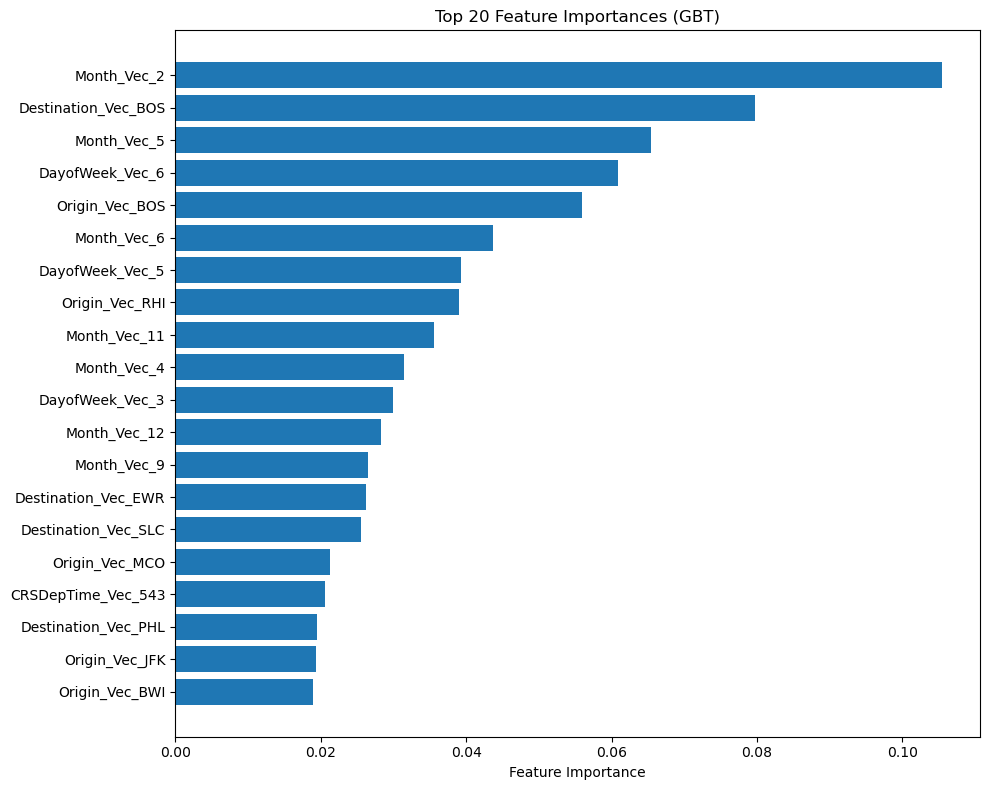

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Grab the best GBT model
best_tree_model = gbt_model.bestModel

# Get the raw importance vector
importances = best_tree_model.featureImportances.toArray()

# Recover feature names from the VectorAssembler metadata
#    We assume `train_data` (or any DataFrame with `features`) is still in scope
feat_meta = train_data.schema["features"].metadata["ml_attr"]["attrs"]
feature_names = [attr["name"] 
                 for attr_list in feat_meta.values() 
                 for attr in attr_list]

# Build a Pandas DataFrame and sort by importance
imp_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

# Plot the top 20
top_n = 20
top_df = imp_df.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_df["feature"][::-1], top_df["importance"][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (GBT)")
plt.tight_layout()
plt.show()


## Model Persistence and Inference 

#### Save the best model

In [37]:
best_tree_model.write().overwrite().save("./best_model/")

#### Run inference on 2010 test data

In [39]:
preds2010 = best_tree_model.transform(test_df_2010)
auc2010   = binary_eval.evaluate(preds2010)
acc2010   = multi_eval.evaluate(preds2010)
print(f"\n2010 Data --> AUC = {auc2010:.4f}, Accuracy = {acc2010:.4f}")


2010 Data --> AUC = 0.6403, Accuracy = 0.9824
